In [12]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [13]:
air_reserve = pd.read_csv('air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv('hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv('air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv('hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv('air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv('store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv('date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv('sample_submission.csv')

In [14]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek

In [15]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

In [16]:
air_store['air_genre_name'].nunique()

14

In [24]:
air_store['air_genre_name'] = air_store['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))

In [25]:
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [7]:
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude,air_genre_name0,air_genre_name1,air_genre_name2,air_genre_name3,air_genre_name4,air_genre_name5,air_genre_name6,air_genre_name7,air_genre_name8,air_genre_name9
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,6,0,0,0,0,0,0,0,0,0
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,6,0,0,0,0,0,0,0,0,0
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,6,0,0,0,0,0,0,0,0,0
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,6,0,0,0,0,0,0,0,0,0
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,6,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,5,2,0,0,0,0,0,0,0,0
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,0,0,0,0,0,0,0,0,0,0
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,0,0,0,0,0,0,0,0,0,0
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,9,0,0,0,0,0,0,0,0,0


In [31]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
air_store

,store_id,air_genre_name,air_area_name,latitude,longitude,genre_count_per_area,air_area_name0
0,air_0f0cdeee6c9bf3d7,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,4,Hyōgo-ken
1,air_7cc17a324ae5c7dc,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,4,Hyōgo-ken
2,air_fee8dcf4d619598e,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,4,Hyōgo-ken
3,air_a17f0778617c76e2,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,4,Hyōgo-ken
4,air_83db5aff8f50478e,6,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,13,Tōkyō-to
...,...,...,...,...,...,...,...
824,air_9bf595ef095572fb,5,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,2,Tōkyō-to
825,air_764f71040a413d4d,0,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,2,Tōkyō-to
826,air_10bbe8acd943d8f6,0,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,2,Tōkyō-to
827,air_7514d90009613cd6,9,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,2,Hokkaidō


<AxesSubplot:>

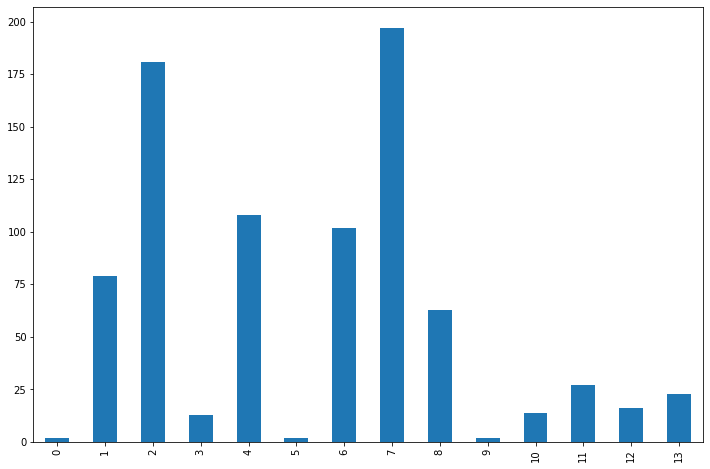

In [32]:
genre_counts = air_store['air_genre_name'].value_counts()
fig = plt.figure(figsize = (12, 8))
genre_counts.plot.bar(x = 'air_genre_name')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


<Figure size 864x576 with 0 Axes>

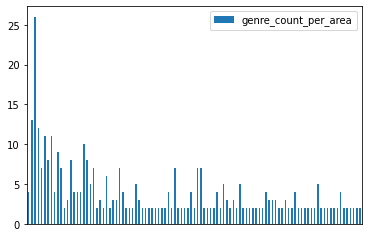

In [33]:
air_store['genre_count_per_area'] = air_store.groupby(['air_genre_name','air_area_name'])['store_id'].transform('count')
fig = plt.figure(figsize = (12, 8))
air_store.plot.bar(x='air_area_name', y='genre_count_per_area', rot=0)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

In [34]:
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

#골든 위크
date_info['golden_week'] = (((date_info['visit_date'].str[5:7] == '04') & (date_info['visit_date'].str[8:10].isin(['29','30']))) |\
                            ((date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['01','02', '03', '04', '05'])))|
                           ((date_info['visit_date'].str[0:5]== '2017') & (date_info['visit_date'].str[5:7]== '05') & (date_info['visit_date'].str[8:10].isin(['06','07'])))).astype(int)
                                                                                                                                                              

data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2','golden_week']], on=['visit_date'],how='left')

In [ ]:
import math 

In [55]:
data['air_store_id2'] = lbl.fit_transform(data['store_id'])
data['month'] = pd.to_datetime(date_info['visit_date']).dt.month

In [43]:
data['id_dow_visitor_max']= data.groupby(['store_id', 'dow'])['visitors'].transform(max)
data['id_dow_visitor_min']= data.groupby(['store_id', 'dow'])['visitors'].transform(min)
data['id_dow_visitor_mean']= data.groupby(['store_id', 'dow'])['visitors'].transform(np.mean)

In [44]:
data['genre_dow_visitor_min']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(min)
data['genre_dow_visitor_max']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(max)
data['genre_dow_visitor_mean']= data.groupby(['air_genre_name', 'dow'])['visitors'].transform(np.mean)

## 모델 구성 및 결과 예측

In [58]:
train_size = len(air_visit)
train = data[:train_size]
test = data[train_size:]

In [59]:
train.columns

Index(['store_id', 'visit_date', 'visitors', 'id', 'dow', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'genre_count_per_area',
       'air_area_name0', 'holiday_flg', 'holiday_flg2', 'golden_week',
       'id_dow_visitor_max', 'id_dow_visitor_min', 'id_dow_visitor_mean',
       'genre_dow_visitor_min', 'genre_dow_visitor_max',
       'genre_dow_visitor_mean', 'air_store_id2', 'month'],
      dtype='object')

In [60]:
col = ['dow', 'air_genre_name', 'air_area_name0','genre_count_per_area', 'holiday_flg', 'holiday_flg2', 'month', 'golden_week',
      'genre_dow_visitor_min', 'genre_dow_visitor_max','genre_dow_visitor_mean','id_dow_visitor_max','id_dow_visitor_min',
      'id_dow_visitor_mean','air_store_id2']
col

['dow',
 'air_genre_name',
 'air_area_name0',
 'genre_count_per_area',
 'holiday_flg',
 'holiday_flg2',
 'month',
 'golden_week',
 'genre_dow_visitor_min',
 'genre_dow_visitor_max',
 'genre_dow_visitor_mean',
 'id_dow_visitor_max',
 'id_dow_visitor_min',
 'id_dow_visitor_mean',
 'air_store_id2']

In [61]:
import lightgbm as lgb

In [62]:
params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

In [64]:
lgb_train = lgb.Dataset(train[col], train['visitors'])
lgb_test = lgb.Dataset(test[col], test['visitors'])

gbm = lgb.train(params,lgb_train,2300)
pred = gbm.predict(test[col])

In [65]:
test['visitors'] = np.expm1(pred)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
sub = test[['id','visitors']].copy()
sub.to_csv('submission.csv', index=False)

## 이상치 제거(하는중)

In [35]:
def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

In [37]:
air_reserve

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,4
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,4
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,4
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,4
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,4
...,...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6,2017-05-29,2017-04-17,0
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8,2017-05-30,2017-04-19,1
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3,2017-05-31,2017-04-12,2
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10,2017-05-31,2017-04-19,2


In [43]:
from datetime import datetime

air_reserve['differ']  = pd.to_datetime(air_reserve['visit_date']) - pd.to_datetime(air_reserve['reserve_date'])

In [50]:
air_reserve['differ'] = air_reserve['differ'].astype(str)
air_reserve['differ'] = air_reserve['differ'].apply(lambda x : x.split(" ")[0])

In [61]:
air_reserve['differ'] = air_reserve['differ'].astype(int)

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


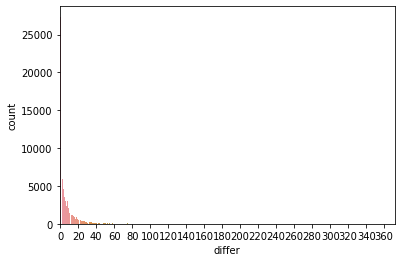

In [60]:
ax = sns.countplot(air_reserve['differ'])
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [64]:
famous_res_id = air_reserve[air_reserve['differ'] > 300]['store_id'].unique()

In [97]:
famous_res_id

array(['air_a17f0778617c76e2', 'air_f068442ebb6c246c',
       'air_2a485b92210c98b5', 'air_6b9fa44a9cf504a1',
       'air_e7fbee4e3cfe65c5', 'air_f911308e19d64236'], dtype=object)

In [89]:
air_reserve[(air_reserve['differ'] > 300) & (air_reserve['store_id'] == 'air_a17f0778617c76e2')]

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow,differ
21547,air_a17f0778617c76e2,2016-11-11 18:00:00,2016-01-05 17:00:00,16,2016-11-11,2016-01-05,4,311
21570,air_a17f0778617c76e2,2016-11-11 18:00:00,2016-01-08 21:00:00,9,2016-11-11,2016-01-08,4,308
21589,air_a17f0778617c76e2,2016-11-11 18:00:00,2016-01-07 21:00:00,7,2016-11-11,2016-01-07,4,309
21743,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-06 13:00:00,5,2016-11-11,2016-01-06,4,310
21744,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-12 00:00:00,4,2016-11-11,2016-01-12,4,304
21746,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-13 15:00:00,4,2016-11-11,2016-01-13,4,303
21747,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-07 17:00:00,6,2016-11-11,2016-01-07,4,309
21748,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-09 01:00:00,4,2016-11-11,2016-01-09,4,307
21750,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-04 21:00:00,72,2016-11-11,2016-01-04,4,312
21752,air_a17f0778617c76e2,2016-11-11 19:00:00,2016-01-10 14:00:00,2,2016-11-11,2016-01-10,4,306


In [93]:
data[(data['store_id'] == 'air_a17f0778617c76e2') & (data['visit_date'] == '2016-11-11')]

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,holiday_flg,holiday_flg2,golden_week,month


In [ ]:
data[(data['store_id'] == 'air_a17f0778617c76e2') & (data['visit_date'] == '2016-11-11')]

<AxesSubplot:xlabel='visit_date'>

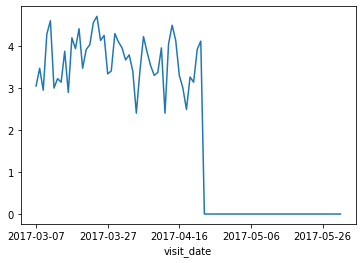

In [94]:
data[data['store_id'] == 'air_a17f0778617c76e2'].groupby(['visit_date'])['visitors'].sum().plot()

In [72]:
air_visit[air_visit['store_id'].isin(famous_res_id)].groupby('store_id')['visitors'].sum()

store_id
air_2a485b92210c98b5     2402
air_6b9fa44a9cf504a1     2513
air_a17f0778617c76e2     2096
air_e7fbee4e3cfe65c5    10220
air_f068442ebb6c246c     3735
air_f911308e19d64236    14816
Name: visitors, dtype: int64

In [83]:
air_visit.groupby('store_id')['visitors'].sum().sort_values().describe()

count      829.000000
mean      6378.351025
std       3919.690328
min        190.000000
25%       3328.000000
50%       5474.000000
75%       8791.000000
max      18717.000000
Name: visitors, dtype: float64

In [85]:
data[data['store_id'] == "air_a17f0778617c76e2"]

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,genre_count_per_area,holiday_flg,holiday_flg2,golden_week,month
108729,air_a17f0778617c76e2,2017-03-07,3.044522,air_a17f0778617c76e2_2017-03-07,1,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108730,air_a17f0778617c76e2,2017-03-08,3.465736,air_a17f0778617c76e2_2017-03-08,2,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108731,air_a17f0778617c76e2,2017-03-09,2.944439,air_a17f0778617c76e2_2017-03-09,3,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108732,air_a17f0778617c76e2,2017-03-10,4.276666,air_a17f0778617c76e2_2017-03-10,4,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,3
108733,air_a17f0778617c76e2,2017-03-11,4.595120,air_a17f0778617c76e2_2017-03-11,5,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272578,air_a17f0778617c76e2,2017-05-27,0.000000,air_a17f0778617c76e2_2017-05-27,5,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,1,0,5
272579,air_a17f0778617c76e2,2017-05-28,0.000000,air_a17f0778617c76e2_2017-05-28,6,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,1,0,5
272580,air_a17f0778617c76e2,2017-05-29,0.000000,air_a17f0778617c76e2_2017-05-29,0,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,5
272581,air_a17f0778617c76e2,2017-05-30,0.000000,air_a17f0778617c76e2_2017-05-30,1,6,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,3,4,0,0,0,5


In [69]:
air_reserve[air_reserve['store_id'].isin(famous_res_id)]

,store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,dow,differ
57,air_f911308e19d64236,2016-01-04 18:00:00,2016-01-04 15:00:00,2,2016-01-04,2016-01-04,0,0
99,air_f911308e19d64236,2016-01-06 12:00:00,2016-01-06 11:00:00,2,2016-01-06,2016-01-06,2,0
100,air_f911308e19d64236,2016-01-06 13:00:00,2016-01-04 11:00:00,2,2016-01-06,2016-01-04,2,2
135,air_f911308e19d64236,2016-01-06 20:00:00,2016-01-06 17:00:00,2,2016-01-06,2016-01-06,2,0
140,air_6b9fa44a9cf504a1,2016-01-06 23:00:00,2016-01-06 23:00:00,2,2016-01-06,2016-01-06,2,0
...,...,...,...,...,...,...,...,...
92299,air_f911308e19d64236,2017-05-20 11:00:00,2017-01-04 17:00:00,29,2017-05-20,2017-01-04,5,136
92317,air_2a485b92210c98b5,2017-05-21 00:00:00,2017-04-18 21:00:00,7,2017-05-21,2017-04-18,6,33
92322,air_2a485b92210c98b5,2017-05-21 19:00:00,2017-04-13 19:00:00,28,2017-05-21,2017-04-13,6,38
92334,air_6b9fa44a9cf504a1,2017-05-24 19:00:00,2017-04-06 18:00:00,4,2017-05-24,2017-04-06,2,48
